<div align="center">
    <img src="images/alongroute.png" style="width:200px;">
    <h4><i>Initial approaches on:</i></h4>
    <h1>Exploration of assimilation techniques</h1>

<img src="images/cover1.png" style="width:600px;">

<p style="text-align: center;"><strong>Date:</strong> 29 Sept, 2023</p>
<p style="text-align: center;"><strong>Name:</strong> Pavlos Patsonis</p>

In this Notebook are explored some initial assimilation techniques of observations in a (10,10) 2D grid. The purpose is to create a simplified simulation of assimilating ground truth data (NRT satellite observations) in the layer that represents the area of interest of the ocean. Firstly, I study a **Gaussian approach** of Optimal Interpolation and playing around with the *sigma* parameter. After that, I explore a **Power law variation** and an **Exponential** approach, tweeking the *power* and the *decay rate* parameters respectively. In the end, I present some other ideas in progress. 

# Table of contents

- [1 - Gaussian](#1)
- [2 - Power Law variation](#2)
- [3 - Exponential](#3)
- [4 - Work in progress](#4)
    - [4.1 - Error minimization](#4.1)
    - [4.2 - Kalman Filtering](#4.2)

<a name='1'></a>
# 1 - Gaussian

The equation thet calculates the weight of neighbor points around the observation is given below:

${W}_{gaussian} = \exp\left(-{0.5}\left(\frac{\text{distance}}{\sigma}\right)^2\right)$

If the parameter **σ** is decreased, then the range of influence of the observations on the 2D grid is decreased as well. 

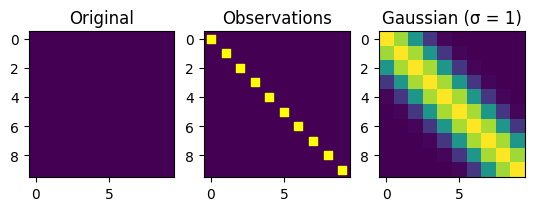

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_weight(distance, sigma=1.0):
    return np.exp(-0.5 * (distance / sigma) ** 2)

def correct_grid_gaussian(_X, observations, range_of_influence=2):
    X = _X.copy()
    for row, col, observed_value in observations:
        for i in range(max(0, row - range_of_influence), min(X.shape[0], row + range_of_influence + 1)):
            for j in range(max(0, col - range_of_influence), min(X.shape[1], col + range_of_influence + 1)):
                distance = np.sqrt((row - i)**2 + (col - j)**2)
                weight = gaussian_weight(distance)
                X[i, j] = (1 - weight) * X[i, j] + weight * observed_value
    return X

# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X = np.zeros((10, 10))

# Simulated satellite observations of significant wave height at random positions
# Each observation is a tuple (row, column, observed_value)
observations = [(i, i, 100) for i in range(10)]

X_corrected_gaussian = correct_grid_gaussian(X, observations)

# Plot the original grid
plt.subplot(131)
plt.imshow(X, cmap='viridis')
plt.title("Original")

# Plot just the observations
plt.subplot(132)
plt.imshow(X, cmap='viridis')
for row, col, observed_value in observations:
    plt.scatter(col, row, c='yellow', marker='s')
plt.title("Observations")

# Plot the grid with Gaussian assimilation
plt.subplot(133)
plt.imshow(X_corrected_gaussian, cmap='viridis')
plt.title("Gaussian (σ = 1)")

plt.show()

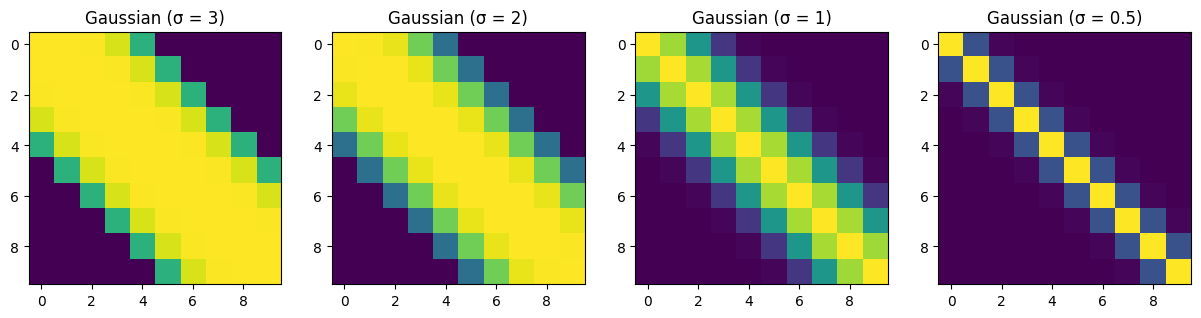

In [2]:
def gaussian_weight(distance, sigma=1.0):
    return np.exp(-0.5 * (distance / sigma) ** 2)

def correct_grid_gaussian(_X, observations, sigma=1.0, range_of_influence=2):
    X = _X.copy()
    for row, col, observed_value in observations:
        for i in range(max(0, row - range_of_influence), min(X.shape[0], row + range_of_influence + 1)):
            for j in range(max(0, col - range_of_influence), min(X.shape[1], col + range_of_influence + 1)):
                distance = np.sqrt((row - i)**2 + (col - j)**2)
                weight = gaussian_weight(distance, sigma)
                X[i, j] = (1 - weight) * X[i, j] + weight * observed_value
    return X

# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X = np.zeros((10, 10))

# Simulated satellite observations of significant wave height at random positions
# Each observation is a tuple (row, column, observed_value)
observations = [(i, i, 100) for i in range(10)]

# Define a list of sigma values to iterate through
sigmas = [3, 2, 1, 0.5]

# Create a plot for each sigma value
plt.figure(figsize=(15, 5))
for i, sigma in enumerate(sigmas):
    X_corrected_gaussian = correct_grid_gaussian(X, observations, sigma=sigma)

    # Create subplots
    plt.subplot(1, 4, i + 1)
    plt.imshow(X_corrected_gaussian, cmap='viridis')
    plt.title(f"Gaussian (σ = {sigma})")

# Adjust layout and show the plots
plt.show()

<a name='2'></a>
# 2 - Power law variation

The equation thet calculates the weight of neighbor points around the observation is given below:

${W}_{powerlaw} = 
\begin{cases} 
1, & \text{if } distance = 0 \\
\frac{1,}{1 + \text{dist}^{p}}, & \text{otherwise}
\end{cases}
$

If the exponent **p** is increased, then the range of influence of the observations on the 2D grid is decreased. 

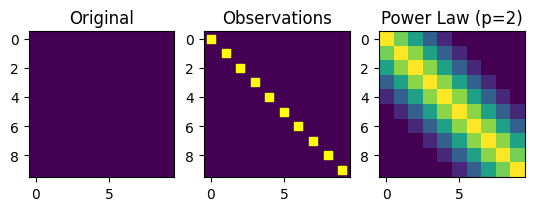

In [3]:
def inverse_distance_weight(distance, power=2):
    if distance == 0:
        return 1.0  # Return the observed value when distance is zero
    else:
        return 1.0 / (1 + distance**power)

def correct_grid_idw(_X, observations, range_of_influence=2):
    X = _X.copy()
    for row, col, observed_value in observations:
        for i in range(max(0, row - range_of_influence), min(X.shape[0], row + range_of_influence + 1)):
            for j in range(max(0, col - range_of_influence), min(X.shape[1], col + range_of_influence + 1)):
                distance = np.sqrt((row - i)**2 + (col - j)**2)
                weight = inverse_distance_weight(distance)
                X[i, j] = (1 - weight) * X[i, j] + weight * observed_value

    return X

# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X_idw = np.zeros((10, 10))

X_corrected_idw = correct_grid_idw(X_idw, observations)

# Plot the original grid
plt.subplot(131)
plt.imshow(X_idw, cmap='viridis')
plt.title("Original")

# Plot just the observations
plt.subplot(132)
plt.imshow(X_idw, cmap='viridis')
for row, col, observed_value in observations:
    plt.scatter(col, row, c='yellow', marker='s')
plt.title("Observations")

# Plot the grid with IDW assimilation
plt.subplot(133)
plt.imshow(X_corrected_idw, cmap='viridis')
plt.title("Power Law (p=2)")

plt.show()

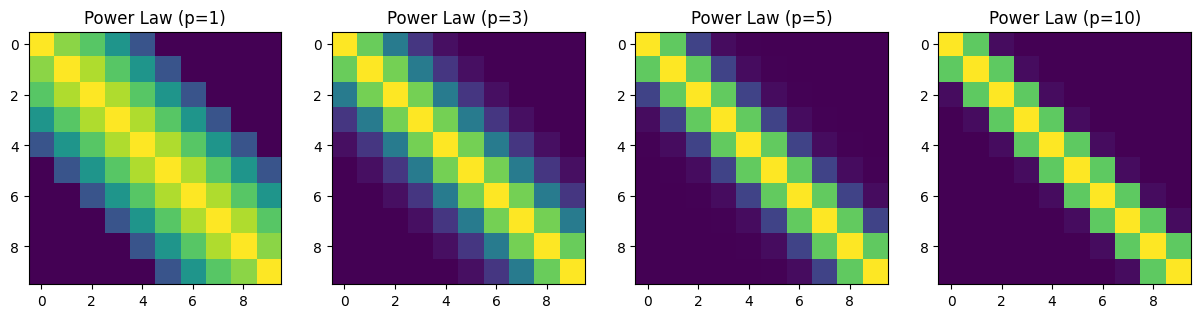

In [4]:
def power_law_weight(distance, power=2):
    if distance == 0:
        return 1.0  # Return the observed value when distance is zero
    else:
        return 1.0 / (1 + distance**power)

def correct_grid_power_law(_X, observations, range_of_influence=2, powers=[2, 5, 10, 20]):
    X = _X.copy()
    for row, col, observed_value in observations:
        for i in range(max(0, row - range_of_influence), min(X.shape[0], row + range_of_influence + 1)):
            for j in range(max(0, col - range_of_influence), min(X.shape[1], col + range_of_influence + 1)):
                for power in powers:
                    distance = np.sqrt((row - i)**2 + (col - j)**2)
                    weight = power_law_weight(distance, power)
                    X[i, j] = (1 - weight) * X[i, j] + weight * observed_value

    return X

# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X_power_law = np.zeros((10, 10))

# Define the power values to iterate
powers = [1, 3, 5, 10]

# Create subplots for each power value
plt.figure(figsize=(15, 5))
for i, power in enumerate(powers):
    # Apply power law assimilation
    X_corrected_power_law = correct_grid_power_law(X_power_law, observations, powers=[power])

    # Plot the grid with power law assimilation for the current power
    plt.subplot(1, 4, i + 1)
    plt.imshow(X_corrected_power_law, cmap='viridis')
    plt.title(f"Power Law (p={power})")

plt.show()


<a name='3'></a>
# 3 - Exponential

The equation thet calculates the weight of neighbor points around the observation is given below:

${W}_{exponential} = \exp\text({-DecayRate} \cdot \text{Distance})$

If the parameter **decay_rate** is increased, then the range of influence of the observations on the 2D grid is decreased. 

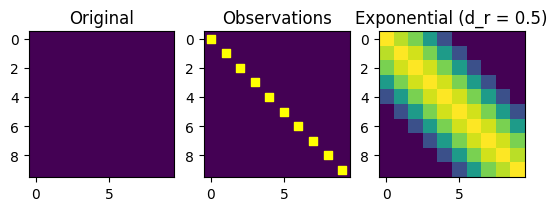

In [5]:
def exponential_weight(distance, decay_rate=0.5):
    return np.exp(-decay_rate * distance)

def correct_grid_exponential(_X, observations, range_of_influence=2, decay_rates=[0.1, 0.5, 1, 2]):
    X = _X.copy()
    for row, col, observed_value in observations:
        for i in range(max(0, row - range_of_influence), min(X.shape[0], row + range_of_influence + 1)):
            for j in range(max(0, col - range_of_influence), min(X.shape[1], col + range_of_influence + 1)):
                distance = np.sqrt((row - i)**2 + (col - j)**2)
                weight = exponential_weight(distance)
                X[i, j] = (1 - weight) * X[i, j] + weight * observed_value

    return X

# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X_exponential = np.zeros((10, 10))

# Apply exponential assimilation
X_corrected_exponential = correct_grid_exponential(X_exponential, observations)

# Plot the original grid
plt.subplot(131)
plt.imshow(X_exponential, cmap='viridis')
plt.title("Original")

# Plot just the observations
plt.subplot(132)
plt.imshow(X_exponential, cmap='viridis')
for row, col, observed_value in observations:
    plt.scatter(col, row, c='yellow', marker='s')
plt.title("Observations")

# Plot the grid with exponential assimilation
plt.subplot(133)
plt.imshow(X_corrected_exponential, cmap='viridis')
plt.title("Exponential (d_r = 0.5)")

plt.show()

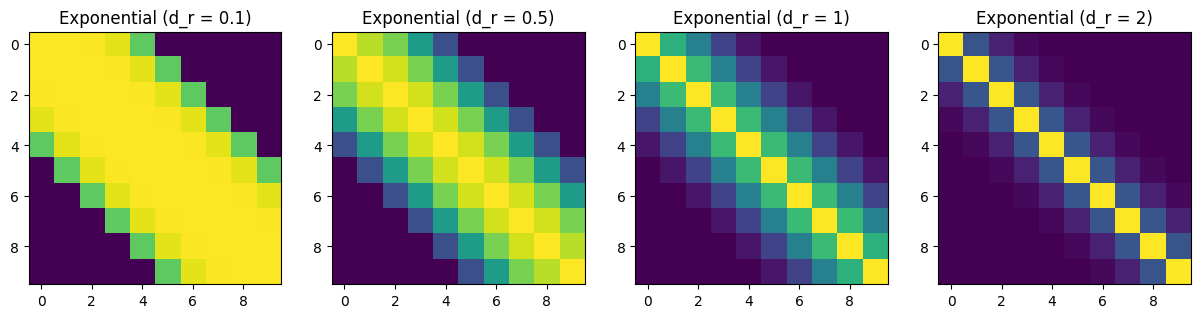

In [6]:
def correct_grid_exponential(_X, observations, range_of_influence=2, decay_rates=[0.1, 0.5, 1, 2]):
    X = _X.copy()
    for row, col, observed_value in observations:
        for i in range(max(0, row - range_of_influence), min(X.shape[0], row + range_of_influence + 1)):
            for j in range(max(0, col - range_of_influence), min(X.shape[1], col + range_of_influence + 1)):
                for decay_rate in decay_rates:
                    distance = np.sqrt((row - i)**2 + (col - j)**2)
                    weight = exponential_weight(distance, decay_rate)
                    X[i, j] = (1 - weight) * X[i, j] + weight * observed_value

    return X

# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X_exponential = np.zeros((10, 10))

# Define the decay rates to iterate
decay_rates = [0.1, 0.5, 1, 2]

# Create subplots for each decay rate
plt.figure(figsize=(15, 5))
for i, decay_rate in enumerate(decay_rates):
    # Apply exponential assimilation
    X_corrected_exponential = correct_grid_exponential(X_exponential, observations, decay_rates=[decay_rate])

    # Plot the grid with exponential assimilation for the current decay rate
    plt.subplot(1, 4, i + 1)
    plt.imshow(X_corrected_exponential, cmap='viridis')
    plt.title(f"Exponential (d_r = {decay_rate})")

plt.show()


<a name='4'></a>
# 4 - Work in progress

<a name='4.1'></a>
## 4.1 - Error minimization

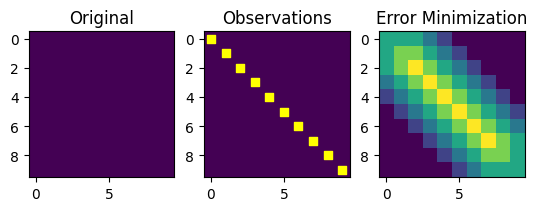

In [7]:
def error_minimization_weight(observed, predicted):
    return 1.0 / np.abs(observed - predicted + 1e-6)

def correct_grid_error_minimization(_X, observations, range_of_influence=2):
    X = _X.copy()
    for row, col, observed_value in observations:
        for i in range(max(0, row - range_of_influence), min(X.shape[0], row + range_of_influence + 1)):
            for j in range(max(0, col - range_of_influence), min(X.shape[1], col + range_of_influence + 1)):
                weight = error_minimization_weight(observed_value, X[i, j])
                X[i, j] = (1 - weight) * X[i, j] + weight * observed_value

    return X

# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X_error_minimization = np.zeros((10, 10))

# Apply error minimization assimilation
X_corrected_error_minimization = correct_grid_error_minimization(X_error_minimization, observations)

# Plot the original grid
plt.subplot(131)
plt.imshow(X_error_minimization, cmap='viridis')
plt.title("Original")

# Plot just the observations
plt.subplot(132)
plt.imshow(X_error_minimization, cmap='viridis')
for row, col, observed_value in observations:
    plt.scatter(col, row, c='yellow', marker='s')
plt.title("Observations")

# Plot the grid with error minimization assimilation
plt.subplot(133)
plt.imshow(X_corrected_error_minimization, cmap='viridis')
plt.title("Error Minimization")

plt.show()


<a name='4.2'></a>
## 4.2 - Kalman Filtering

Here are some attempts to try out the Kalman Filtering technique. I also played around with adding some noise to the grid and the observations. It is not working yet, I included them in case you wanted to take a look. 

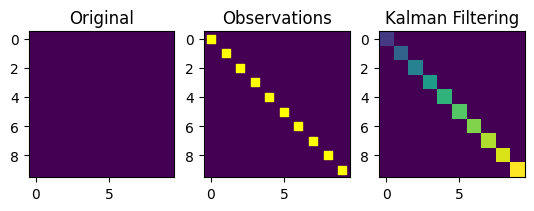

In [8]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def kalman_filter(X, observations, process_noise_std=1.0, measurement_noise_std=10.0):
    num_rows, num_cols = X.shape
    state = np.zeros((num_rows, num_cols))
    
    # Create Kalman filter
    kf = KalmanFilter(dim_x=2, dim_z=1)  # Change dim_x to 2 for 2D grid
    kf.x = np.zeros((2, 1))  # Initialize state as a 2D vector
    kf.F = np.eye(2)  # State transition matrix for 2D vector
    kf.H = np.array([[1, 0]])  # Measurement matrix for 1D observation
    kf.P *= 10
    kf.R *= measurement_noise_std**2
    kf.Q = Q_discrete_white_noise(dim=2, dt=1.0, var=process_noise_std**2)  # Change dim to 2

    for row, col, observed_value in observations:
        measurement = np.array([[observed_value]])
        
        # Predict
        kf.predict()

        # Update
        kf.update(measurement)

        state[row, col] = kf.x[0, 0]

    return state

# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X = np.zeros((10, 10))

# Simulated satellite observations of significant wave height at random positions
# Each observation is a tuple (row, column, observed_value)
observations = [(i, i, 100) for i in range(10)]

# Apply Kalman filtering assimilation
X_corrected = kalman_filter(X, observations)

# Plot the original grid
plt.subplot(131)
plt.imshow(X, cmap='viridis')
plt.title("Original")

# Plot just the observations
plt.subplot(132)
plt.imshow(X, cmap='viridis')
for row, col, observed_value in observations:
    plt.scatter(col, row, c='yellow', marker='s')
plt.title("Observations")

# Plot the grid with Kalman filtering assimilation
plt.subplot(133)
im = plt.imshow(X_corrected, cmap='viridis')
plt.title("Kalman Filtering")
# plt.colorbar(im, fraction=0.046, pad=0.04)

plt.show()


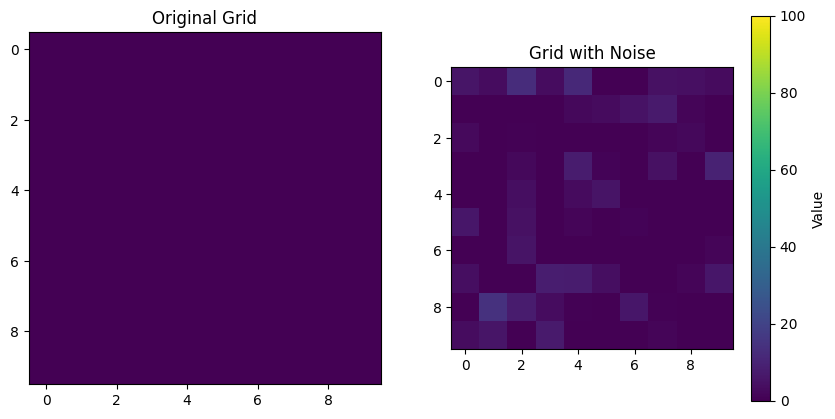

In [9]:
# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X = np.zeros((10, 10))

# Add random noise to the grid
noise_std = 5.0  # Adjust the noise level as needed
noise = np.random.normal(0, noise_std, X.shape)
X_with_noise = X + noise

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Define the color range
vmin = 0
vmax = 100

# Plot the original grid
axs[0].imshow(X, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Original Grid")

# Plot the grid with noise
im = axs[1].imshow(X_with_noise, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Grid with Noise")

# Add colorbar to the right subplot
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('Value')

plt.show()


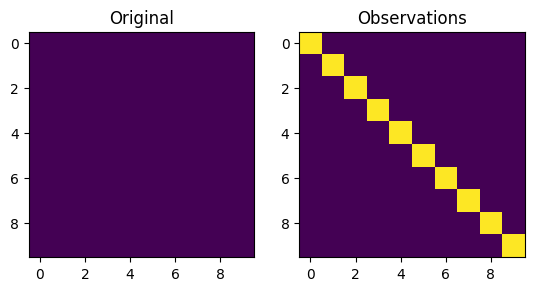

In [10]:
# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X = np.zeros((10, 10))

# Create a new array with 100 in the main diagonal
observations = np.diag(np.full(10, 100))

# Plot the original grid
plt.subplot(121)
plt.imshow(X, cmap='viridis')
plt.title("Original")

# Plot just the observations
plt.subplot(122)
plt.imshow(observations, cmap='viridis')
plt.title("Observations")

plt.show()


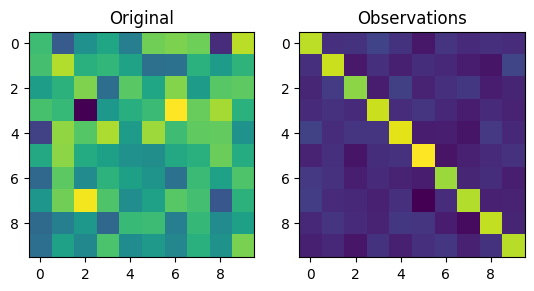

In [11]:
# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X = np.zeros((10, 10))
# Add random noise to the grid
noise_std = 5.0  # Adjust the noise level as needed
noise = np.random.normal(0, noise_std, X.shape)
X_with_noise = X + noise

# Create a new array with 100 in the main diagonal
observations = np.diag(np.full(10, 100))# Add random noise to the grid
noise_std = 5.0  # Adjust the noise level as needed
noise = np.random.normal(0, noise_std, observations.shape)
observations_with_noise = observations + noise

# Plot the original grid
plt.subplot(121)
plt.imshow(X_with_noise, cmap='viridis')
plt.title("Original")

# Plot just the observations
plt.subplot(122)
plt.imshow(observations_with_noise, cmap='viridis')
plt.title("Observations")

plt.show()

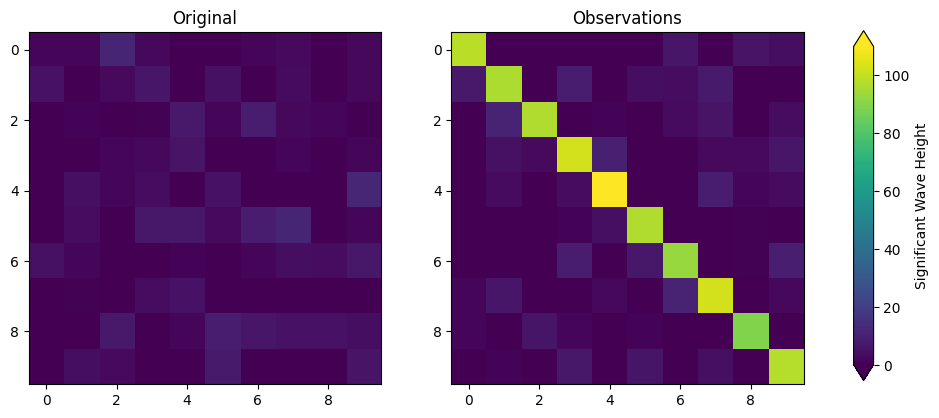

In [12]:
# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X = np.zeros((10, 10))

# Add random noise to the grid
noise_std = 5.0  # Adjust the noise level as needed
noise = np.random.normal(0, noise_std, X.shape)
X_with_noise = X + noise

# Create a new array with 100 in the main diagonal
observations = np.diag(np.full(10, 100))
# Add random noise to the grid
noise_std = 5.0  # Adjust the noise level as needed
noise = np.random.normal(0, noise_std, observations.shape)
observations_with_noise = observations + noise

# Define the colorbar range
vmin = 0
vmax = 110

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original grid
im1 = axs[0].imshow(X_with_noise, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Original")

# Plot the observations
im2 = axs[1].imshow(observations_with_noise, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Observations")

# Create a colorbar for both plots
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = fig.colorbar(im2, cax=cax, extend='both')  # Set extend='both' to indicate values outside the range
cbar.set_label('Significant Wave Height')

plt.show()


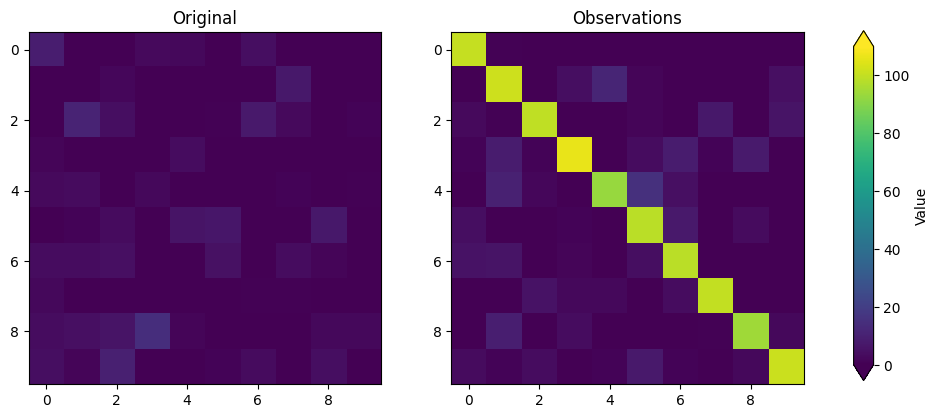

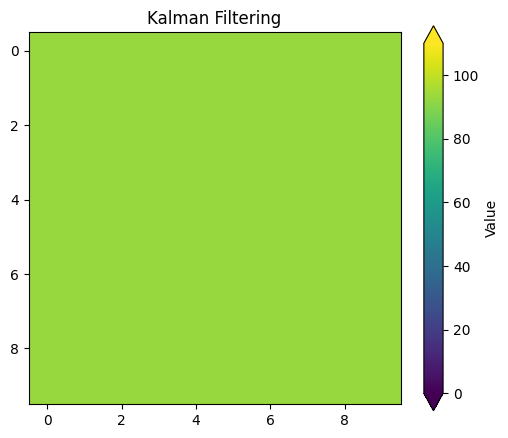

In [13]:
# Create a 10x10 simulated 2D model grid for significant wave height (in meters)
X = np.zeros((10, 10))

# Add random noise to the grid
noise_std = 5.0  # Adjust the noise level as needed
noise = np.random.normal(0, noise_std, X.shape)
X_with_noise = X + noise

# Create a new array with 100 in the main diagonal
observations = np.diag(np.full(10, 100))
# Add random noise to the grid
noise_std = 5.0  # Adjust the noise level as needed
noise = np.random.normal(0, noise_std, observations.shape)
observations_with_noise = observations + noise

# Define the colorbar range
vmin = 0
vmax = 110

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original grid
im1 = axs[0].imshow(X_with_noise, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Original")

# Plot the observations
im2 = axs[1].imshow(observations_with_noise, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Observations")

# Create a colorbar for both plots
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = fig.colorbar(im2, cax=cax, extend='both')  # Set extend='both' to indicate values outside the range
cbar.set_label('Value')

# Kalman Filter Implementation
# Here, we'll implement a simple 1D Kalman filter to estimate the true values of the grid.

# Initialize Kalman filter parameters
initial_state = np.zeros((10, 10))  # Initial state estimate (zero for simplicity)
initial_error_covariance = np.ones((10, 10))  # Initial error covariance (identity matrix for simplicity)
process_noise = 1.0  # Process noise (tune as needed)
measurement_noise = 10.0  # Measurement noise (tune as needed)

state_estimate = initial_state
error_covariance = initial_error_covariance

# Iterate through observations and apply Kalman filter
for i in range(10):
    observation = observations_with_noise[i, i]  # Get the observed value

    # Prediction Step
    # Project the current state estimate ahead
    predicted_state = state_estimate
    predicted_error_covariance = error_covariance + process_noise

    # Update Step
    # Compute the Kalman Gain
    kalman_gain = predicted_error_covariance / (predicted_error_covariance + measurement_noise)

    # Update the state estimate
    state_estimate = predicted_state + kalman_gain * (observation - predicted_state)

    # Update the error covariance
    error_covariance = (1 - kalman_gain) * predicted_error_covariance

# Plot the grid with Kalman filtering assimilation
plt.figure(figsize=(6, 5))
plt.imshow(state_estimate, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Kalman Filtering")
cbar = plt.colorbar(extend='both')
cbar.set_label('Value')

plt.show()
